# Настройки/Импорты

In [1]:
!pip install transformers==4.45.2
!pip install evaluate
!pip install seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import os # для взаимодействия с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import pickle # для сохранения и загрузки объектов
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import torch # для работы с моделями torch
from transformers import T5ForConditionalGeneration, T5Tokenizer # для работы с T5 моделью
from transformers import DataCollatorForSeq2Seq # для сборщика данных (чтобы)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # для обучения модели
from transformers import EarlyStoppingCallback # callback для ранней остановки обучения

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import evaluate # для подсчёта метрик
from transformers.modelcard import parse_log_history # для парсинга логов обучения через Trainer

In [3]:
DATA_DIR = "/kaggle/working/data/" # путь до папки с данными
RESULTS_DIR = "/kaggle/working/results/" # путь до папки с результатами вычислений
EMBEDDING_DIR = "/kaggle/working/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/kaggle/working/models/" # путь до папки с моделями
MODEL_NAME = "utrobinmv/t5_translate_en_ru_zh_small_1024" # название модели для перевода
DATASET_NAME_HF = "aiana94/polynews-parallel"
DATASET_NAME_LOC = "polynews-parallel"

MAX_SEQUENCE_LEN = 256 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
TEST_MAX_SAMPLES = 10000 # максимальное число тестовых примеров
TRAIN_MAX_SAMPLES = 50000 # максимальное число обучающих примеров

EPOCHS = 10 # число эпох обучения
EPOCHS_PATIENCE = 2 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.00001 # learning rate
BATCH_SIZE = 24 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cuda:0.


# Подготовка данных и модели

In [5]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
model

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(65100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(65100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [6]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
tokenizer

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

T5Tokenizer(name_or_path='utrobinmv/t5_translate_en_ru_zh_small_1024', vocab_size=65000, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_

In [7]:
dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
dataset

README.md:   0%|          | 0.00/107k [00:00<?, ?B/s]

train.parquet.gzip:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'provenance'],
        num_rows: 176441
    })
})

In [8]:
dataset["train"][0]

{'src': 'Parliament Does Not Support Amendment Freeing Tymoshenko',
 'tgt': 'Парламент не поддерживает поправку, дающую свободу Тимошенко',
 'provenance': 'wmtnews'}

In [9]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(dataset["train"]) # общее число сэмплов в датасете

    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    data["new_src"] = ["translate to ru: " + sample if idx in regular_idx else "translate to en: " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]
    model_inputs = tokenizer(data["new_src"], text_target=data["new_tgt"], max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True)
    return model_inputs

In [10]:
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки ()
dataset

Map:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 141152
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35289
    })
})

In [11]:
dataset["train"][0]

{'src': "translate to ru: Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'tgt': "Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'input_ids': [21809,
  19,
  4,
  2248,
  31,
  1985,
  32668,
  9922,
  10256,
  3948,
  850,
  887,
  26547,
  38,
  13,
  14997,
  58,
  147,
  31672,
  53,
  19,
  547,
  1736,
  1058,
  5,
  20365,
  9,
  372,
  12878,
  5752,
  58,
  19069,
  88,
  3,
  697,
  131,
  6057,
  13,
  294,
  21000,
  38768,
  6016,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [12]:
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # локальное сохранение датасета (в формате arrow)
# dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # загрузка локально сохранённого датасета

Saving the dataset (0/1 shards):   0%|          | 0/141152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35289 [00:00<?, ? examples/s]

# [Fine-tuning](https://huggingface.co/docs/transformers/tasks/translation) (с использованием PyTorch)

In [13]:
model = T5ForConditionalGeneration.from_pretrained(MODELS_DIR + MODEL_NAME) # загружаем предобученную модель
tokenizer = T5Tokenizer.from_pretrained(MODELS_DIR + MODEL_NAME) # загружаем предобученный токенизатор
dataset_tokenized = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # загрузка локально сохранённого датасета
metric_BLEU = evaluate.load("bleu") # загружаем метрику

In [14]:
print(f"Число обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}.") # считаем число параметров

Число обучаемых параметров: 110724480.


Обрежим датасет, чтобы время обучения не составляло несколько дней.

In [15]:
dataset_tokenized["train"] = dataset_tokenized["train"].select(range(TRAIN_MAX_SAMPLES))
dataset_tokenized["test"] = dataset_tokenized["test"].select(range(TEST_MAX_SAMPLES))
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

Получим токены для обучения, как входа модели, так и таргетов.

In [16]:
dataset_tokenized["train"][0]

{'src': "translate to ru: Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'tgt': "Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'input_ids': [21809,
  19,
  4,
  2248,
  31,
  1985,
  32668,
  9922,
  10256,
  3948,
  850,
  887,
  26547,
  38,
  13,
  14997,
  58,
  147,
  31672,
  53,
  19,
  547,
  1736,
  1058,
  5,
  20365,
  9,
  372,
  12878,
  5752,
  58,
  19069,
  88,
  3,
  697,
  131,
  6057,
  13,
  294,
  21000,
  38768,
  6016,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="pt") # сборщик данных для обучения, return_tensors — тип возвращаемого тензора (pt — Torch, tf — Tensorflow, np — Numpy)

In [18]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

In [19]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    preds_decoded = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds_decoded, labels_decoded = postprocess_text(preds_decoded, labels_decoded)

    result = metric_BLEU.compute(predictions=preds_decoded, references=labels_decoded)
    result = {"bleu": result["bleu"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["mean_len"] = np.mean(prediction_lens)
    result = {k: round(v, 5) for k, v in result.items()} # округляем float до 5 знаков после запятой
    return result

In [20]:
if not os.path.exists(RESULTS_DIR + MODEL_NAME):
    os.makedirs(RESULTS_DIR + MODEL_NAME)

## Обучение модели

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=RESULTS_DIR + MODEL_NAME,
    # evaluation_strategy ="epoch",
    evaluation_strategy="steps", # стратегия оценивания модели, "steps" - через несколько вызовов forward pass (нужен для работы EarlyStoping), "epoch" — по эпохам
    eval_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE), # подсчёт метрик и сохранение происходят каждые eval_steps шагов (нужно для работы для работы EarlyStoping), имитирующие одну эпоху
    save_strategy="steps", # стратегия сохранения модели, "steps" - через несколько вызовов forward pass (нужен для работы EarlyStoping), "epoch" — по эпохам
    save_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE), # для работы должен быть кратен eval_steps, если стратегии стоят как "steps"
    logging_strategy="steps", # стратегия подсчёта метрик на обучающей части
    logging_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE),
    learning_rate=LEARNING_RATE, # шаг обучения
    per_device_train_batch_size=BATCH_SIZE, # размер батча при обучении
    per_device_eval_batch_size=BATCH_SIZE, # размер батча при валидации
    weight_decay=0.01,
    save_total_limit=3, # количество сохраняемых чекпоинтов
    num_train_epochs=EPOCHS,
    predict_with_generate=True,
    
    fp16=True, # проводить ли обучение в float16 вместо float32
    # bf16=False, # проводить обучение в float16 от google (так обучены некоторые модели google и они не умеют работать с обычным fp16 из-за возникающих ошибок переполнения)
    
    load_best_model_at_end=True, # загружать ли в конце обучения чекпоинт с лучшей метрикой (также 100% сохраняет лучший чекпоинт)
    metric_for_best_model="eval_bleu", # название метрики, по которой будет определяться лучший чекпоинт обучения
    greater_is_better=True, # должна ли отслеживаемая метрика увеличиваться
    use_cpu=False, # использовать ли для подсчёта устройства, отличные от CPU
    push_to_hub=False,
    report_to="none" # не запускать wandb backend
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
    tokenizer=tokenizer, # tokenizer -> processing_class
    # processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EPOCHS_PATIENCE)] # callback_и для обучения, EarlyStoppingCallback — ранняя остановка
)

trainer.train()

Step,Training Loss,Validation Loss,Bleu,Mean Len
2083,0.383600,0.350508,0.260550,29.175600
4166,0.378600,0.346293,0.263200,29.053000
6249,0.367900,0.343896,0.264080,29.147400
8332,0.365300,0.342578,0.264810,29.052800
10415,0.358000,0.341750,0.265200,29.057600
12498,0.355900,0.341368,0.266100,29.072600
14581,0.353800,0.340581,0.266180,29.083500
16664,0.356300,0.340680,0.266630,29.115800
18747,0.353000,0.340575,0.266300,29.087200
20830,0.350600,0.340521,0.266430,29.088500


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=20830, training_loss=0.3647063615627719, metrics={'train_runtime': 38369.3812, 'train_samples_per_second': 13.031, 'train_steps_per_second': 0.543, 'total_flos': 5.513944793849856e+16, 'train_loss': 0.3647063615627719, 'epoch': 9.995201535508638})

In [23]:
trainer.model.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение модели
trainer.tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение токенизатора
# trainer.processing_class.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение токенизатора

('/kaggle/working/models/utrobinmv/t5_translate_en_ru_zh_small_1024_finetuned/tokenizer_config.json',
 '/kaggle/working/models/utrobinmv/t5_translate_en_ru_zh_small_1024_finetuned/special_tokens_map.json',
 '/kaggle/working/models/utrobinmv/t5_translate_en_ru_zh_small_1024_finetuned/spiece.model',
 '/kaggle/working/models/utrobinmv/t5_translate_en_ru_zh_small_1024_finetuned/added_tokens.json')

In [24]:
trainer.state.log_history[:5]

[{'loss': 0.407,
  'grad_norm': 0.5023131966590881,
  'learning_rate': 9.760076775431862e-06,
  'epoch': 0.2399232245681382,
  'step': 500},
 {'loss': 0.3972,
  'grad_norm': 0.6018129587173462,
  'learning_rate': 9.520153550863724e-06,
  'epoch': 0.4798464491362764,
  'step': 1000},
 {'loss': 0.3914,
  'grad_norm': 0.5582142472267151,
  'learning_rate': 9.280230326295585e-06,
  'epoch': 0.7197696737044146,
  'step': 1500},
 {'loss': 0.3836,
  'grad_norm': 0.48604750633239746,
  'learning_rate': 9.040307101727449e-06,
  'epoch': 0.9596928982725528,
  'step': 2000},
 {'eval_loss': 0.350508451461792,
  'eval_bleu': 0.26055,
  'eval_mean_len': 29.1756,
  'eval_runtime': 2323.7376,
  'eval_samples_per_second': 4.303,
  'eval_steps_per_second': 0.179,
  'epoch': 0.9995201535508638,
  'step': 2083}]

In [25]:
history = parse_log_history(trainer.state.log_history)
history

({'train_runtime': 38369.3812,
  'train_samples_per_second': 13.031,
  'train_steps_per_second': 0.543,
  'total_flos': 5.513944793849856e+16,
  'train_loss': 0.3647063615627719,
  'epoch': 9.995201535508638,
  'step': 20830},
 [{'Training Loss': 0.3836,
   'Epoch': 0.9995201535508638,
   'Step': 2083,
   'Validation Loss': 0.350508451461792,
   'Bleu': 0.26055,
   'Mean Len': 29.1756},
  {'Training Loss': 0.3786,
   'Epoch': 1.9990403071017275,
   'Step': 4166,
   'Validation Loss': 0.34629255533218384,
   'Bleu': 0.2632,
   'Mean Len': 29.053},
  {'Training Loss': 0.3679,
   'Epoch': 2.998560460652591,
   'Step': 6249,
   'Validation Loss': 0.3438960611820221,
   'Bleu': 0.26408,
   'Mean Len': 29.1474},
  {'Training Loss': 0.3653,
   'Epoch': 3.998080614203455,
   'Step': 8332,
   'Validation Loss': 0.3425775468349457,
   'Bleu': 0.26481,
   'Mean Len': 29.0528},
  {'Training Loss': 0.358,
   'Epoch': 4.997600767754319,
   'Step': 10415,
   'Validation Loss': 0.34175002574920654,
  

In [26]:
history = pd.DataFrame(history[1]) # преобразовываем историю обучения в DataFrame (данные на самом деле про test часть, хоть в них и не указано 'eval_')
history

,Training Loss,Epoch,Step,Validation Loss,Bleu,Mean Len
0,0.3836,0.999520,2083,0.350508,0.26055,29.1756
1,0.3786,1.999040,4166,0.346293,0.26320,29.0530
2,0.3679,2.998560,6249,0.343896,0.26408,29.1474
3,0.3653,3.998081,8332,0.342578,0.26481,29.0528
4,0.3580,4.997601,10415,0.341750,0.26520,29.0576
5,0.3559,5.997121,12498,0.341368,0.26610,29.0726
6,0.3538,6.996641,14581,0.340581,0.26618,29.0835
7,0.3563,7.996161,16664,0.340680,0.26663,29.1158
8,0.3530,8.995681,18747,0.340575,0.26630,29.0872
9,0.3506,9.995202,20830,0.340521,0.26643,29.0885


In [27]:
def plot_history(history):
    fig, axes = plt.subplots(ncols=3, figsize=(24,7)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

    # берём данные об обучении
    epochs = history["Epoch"].values
    loss_train = history["Training Loss"].values # значение loss при обучении
    loss_test = history["Validation Loss"].values # значение loss при валидации
    bleu_test = history["Bleu"].values # значение BLEU при валидации
    len_test = history["Mean Len"].values # среднее количество токенов предсказания при валидации
    best_epoch = bleu_test.argmax() + 1 # эпоха с наилучшей метрикой (+1 из-за нумерации с 0)

    axes[0].plot(epochs, loss_train, color="b", label="При обучении") # построение графика
    axes[0].plot(epochs, loss_test, color="r", label="При валидации") # построение графика
    axes[0].plot(best_epoch, loss_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
    axes[0].set_xlabel("Эпоха") # подпись по оси OX
    axes[0].set_ylabel("Loss") # подпись по оси OY
    axes[0].grid(True) # отображение сетки на графике
    axes[0].legend() # отображение подписей графиков

    axes[1].plot(epochs, bleu_test, color="r", label="При валидации") # построение графика
    axes[1].plot(best_epoch, bleu_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[1].set_title("Изменение значения BLEU в зависимости от эпохи обучения") # название фигуры
    axes[1].set_xlabel("Эпоха") # подпись по оси OX
    axes[1].set_ylabel("BLEU") # подпись по оси OY
    axes[1].grid(True) # отображение сетки на графике
    axes[1].legend() # отображение подписей графиков

    axes[2].plot(epochs, len_test, color="r", label="При валидации") # построение графика
    axes[2].plot(best_epoch, len_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[2].set_xticklabels(axes[2].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[2].set_title("Изменение среднего числа токенов предсказания в зависимости от эпохи обучения") # название фигуры
    axes[2].set_xlabel("Эпоха") # подпись по оси OX
    axes[2].set_ylabel("Количество токенов предсказания") # подпись по оси OY
    axes[2].grid(True) # отображение сетки на графике
    axes[2].legend() # отображение подписей графиков

    plt.show() # показ фигуры

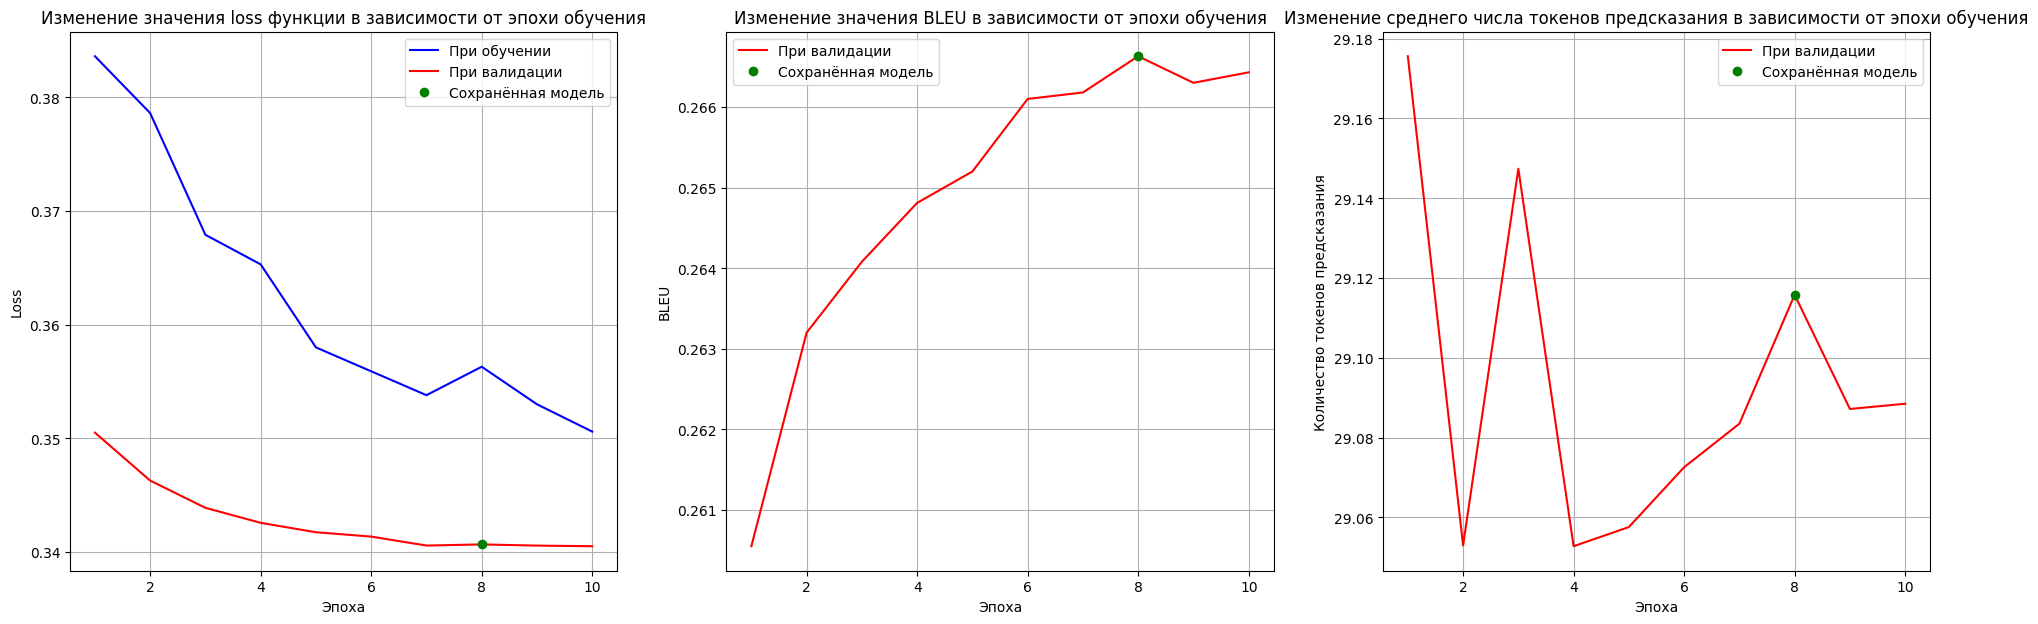

In [28]:
plot_history(history)